# Годовой проект - Определение популярности геолокации для размещения банкомата

`Куратор`: 
- Ковалева Александра  
    
`Команда`:
- Цуканов Николай Сергеевич
- Исхаков Ильдус Халитович
- Устименко Кирилл Александрович
- Волокитина Анастасия Евгеньевна

## Исходные данные

`id` - идентификатор банкомата  
`atm_group` - принадлежность банкомата к группе  
`address` - адрес банкомата на английском  
`address_rus` - адрес банкомата на русском  
`lat` - широта  
`long` - долгота    
`target` - целевая метрика  

Импортируем библиотеки:

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

Загрузим данные:

In [7]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)

In [8]:
train_rows, train_columns = df_train.shape
test_rows, test_columns = df_test.shape
print(f'Данные для обучающей выборки состоят из {train_rows} строки и {train_columns} столбцов.') 
print(f'Данные для тестовой выборки состоят из {test_rows} строк и {test_columns} столбцов.') 

Данные для обучающей выборки состоят из 6261 строки и 7 столбцов.
Данные для тестовой выборки состоят из 2504 строк и 6 столбцов.


Посмотрим на наши наблюдения:

In [10]:
df_train.sample(5)

,id,atm_group,address,address_rus,lat,long,target
3862,8746.0,496.5,SOVETSKAYA 73A NERCHINSK,"Советская улица, 73А, Нерчинск, Забайкальский ...",51.975677,116.588155,-0.109084
4206,2220.0,3185.5,"MAJOROVA, 18 OMSK",NaN,NaN,NaN,-0.140890
2337,3349.0,8083.0,"GILYAROVSKOGO, 42 Moskva","улица Гиляровского, 42, Москва, Россия, 129110",55.783554,37.632871,0.218608
951,7812.0,5478.0,"D. 188, UL. KIROVA BELOGORSK G","улица Кирова, 186, Белогорск, Амурская область...",50.915733,128.498899,0.047313
2017,6517.0,5478.0,"D. 24B, UL. LENINA PROTVINO G","улица Ленина, 24А, Протвино, Московская област...",54.874906,37.221290,-0.024476


## Часть 1 | EDA и визуализация

__1. Посмотрим на типы данных:__

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6261 entries, 0 to 6260
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6261 non-null   float64
 1   atm_group    6261 non-null   float64
 2   address      6261 non-null   object 
 3   address_rus  5957 non-null   object 
 4   lat          5957 non-null   float64
 5   long         5957 non-null   float64
 6   target       6261 non-null   float64
dtypes: float64(5), object(2)
memory usage: 391.3+ KB


__2. Посмотрим на наличие пропусков:__

In [15]:
df_train.isna().sum()

id               0
atm_group        0
address          0
address_rus    304
lat            304
long           304
target           0
dtype: int64

In [16]:
data_gaps = round(100 * df_train[df_train['address_rus'].isna()].shape[0] / df_train.shape[0], 2)

In [18]:
print(f'Имеется 304 банкомата ({data_gaps}% от общего числа) без указания адреса на русском и географических координат.')

Имеется 304 банкомата (4.86% от общего числа) без указания адреса на русском и географических координат.


__3. Посмотрим на наличие полных дублей:__

In [27]:
df_train.duplicated().sum()

0

Дубли отсутствуют.

__4. Посмотрим на описательные статистики:__

Посмотрим на количественные переменные:

In [32]:
pd.options.display.float_format = '{:,.2f}'.format

In [34]:
df_train.describe(include='number')

,id,atm_group,lat,long,target
count,"6,261.00","6,261.00","5,957.00","5,957.00","6,261.00"
mean,"4,419.12","4,417.94",54.16,63.52,0.00
std,"2,547.21","2,430.41",4.35,33.02,0.09
min,5.00,32.00,42.06,19.94,-0.15
25%,"2,228.00","1,942.00",52.25,37.86,-0.06
50%,"4,392.00","5,478.00",55.07,48.58,-0.02
75%,"6,660.00","5,478.00",56.12,84.95,0.04
max,"8,811.00","8,083.00",69.49,173.71,0.22


In [36]:
df_test.describe(include='number')

,id,atm_group,lat,long
count,"2,504.00","2,504.00","2,388.00","2,388.00"
mean,"4,368.24","4,379.68",54.08,63.45
std,"2,530.93","2,421.99",4.29,32.21
min,1.00,32.00,42.65,20.44
25%,"2,146.50","1,942.00",52.21,37.81
50%,"4,437.50","5,478.00",55.04,49.15
75%,"6,468.50","5,478.00",56.10,84.95
max,"8,808.00","8,083.00",69.50,160.85


Широта может иметь значения от 0 до 90 градусов, долгота - от 0 до 180 градусов. Наши наблюдения не выходят за рамки этих пределов.  

Посмотрим на категориальные переменные:

In [40]:
df_train.describe(include='object')

,address,address_rus
count,6261,5957
unique,5343,4553
top,"HOROSHEVSKOE SH,V38 MOSKVA","улица Ватутина, 107, Новосибирск, Россия, 630024"
freq,7,8


In [42]:
df_test.describe(include='object')

,address,address_rus
count,2504,2388
unique,2138,1952
top,30/32 KUTUZOVSKIY PR. MOSCOW,"Кутузовский проспект, 30, Москва, Россия, 121165"
freq,6,6


__5. Посмотрим сколько банкоматов принадлежит той или иной группе:__

In [45]:
df_train.groupby('atm_group', as_index=False).agg(atm_count=('atm_group', 'count')).sort_values(by='atm_count', ascending=False)

,atm_group,atm_count
5,"5,478.00",2662
3,"1,942.00",1160
6,"8,083.00",1050
1,496.50,616
4,"3,185.50",594
2,"1,022.00",136
0,32.00,43


__6. Уберем возможные пробелы для наших записей:__

In [48]:
df_train['address_rus'] = df_train['address_rus'].apply(lambda x: x.strip() if pd.notnull(x) else None)
df_test['address_rus'] = df_test['address_rus'].apply(lambda x: x.strip() if pd.notnull(x) else None)

__7. Посмотрим на длину записей адресов:__

In [51]:
df_train['len_address'] = df_train['address_rus'].apply(lambda x: len(x) if x != None else None)

In [53]:
df_train['len_address'].min(), df_train['len_address'].max()

(27.0, 144.0)

Посмотрим на самый длинный адрес в наших данных:

In [56]:
df_train[df_train['len_address'] == 144]['address_rus'].loc[3579]

'Волжская улица, 1, посёлок городского типа Ванино, городское поселение Рабочий Посёлок Ванино, Ванинский район, Хабаровский край, Россия, 682860'

Каких-то аномально длинных адресов нет.

__8. Посмотрим на формат записей адресов банкоматов на русском:__

In [60]:
df_train['address_rus'][0]

'улица А.О. Емельянова, 34, Южно-Сахалинск, Сахалинская область, Россия'

In [62]:
df_train['address_rus'][10]

'Большая Московская улица, 90А, Владимир, Россия, 600000'

In [64]:
df_train['address_rus'][1343]

'Магаданская улица, 31, посёлок Хандыга, Томпонский муниципальный район, Республика Саха (Якутия), Россия, 678720'

__9. Спарсим наши адреса на русском на составляющие: `почтовый индекс`, `страна`, `город`, `улица`, `дом`:__

9.1 Достанем из адреса почтовый индекс, если он имеется:__

In [91]:
def get_postal_code(address: str) -> str:
    """
    Функция возвращает индекс из строки адреса
    """
    address = address.split(', ')
    if address[-1].isdigit():
        return address[-1]
    else:
        return None

In [93]:
df_train['postal_code'] = df_train['address_rus'].apply(lambda x: get_postal_code(x) if pd.notnull(x) else None)
df_test['postal_code'] = df_test['address_rus'].apply(lambda x: get_postal_code(x) if pd.notnull(x) else None)

В России принята 6-значная система почтовых индексов XXXYYY, где XXX - код субъекта федерации, YYY - номер почтового отделения в нем, но крупные города, такие как, например, Москва имеет несколько кодов. Проверим какой длины имеющиеся индексы в наших данных:

In [96]:
df_train['len_postal_code'] = df_train['postal_code'].apply(lambda x: len(x) if pd.notnull(x) else None)

In [98]:
df_train['len_postal_code'].unique()

array([nan,  6.])

Все имеющиеся почтовые индексы имеют нужную длину.

9.2 Достанем из адреса страну, если она имеется:

In [102]:
def get_country(address: str) -> str:
    """
    Функция возвращает страну из строки адреса
    """
    address = address.split(', ')
    if address[-1].isalpha():
        return address[-1]
    elif address[-2].isalpha():
        return address[-2]
    else:
        return None

In [104]:
df_train['country'] = df_train['address_rus'].apply(lambda x: get_country(x) if pd.notnull(x) else None)
df_test['country'] = df_test['address_rus'].apply(lambda x: get_country(x) if pd.notnull(x) else None)

In [106]:
df_train['country'].unique()

array(['Россия', None], dtype=object)

Без неожиданностей - все адреса банкоматов в России.

9.3 Достанем из адреса населенный пункт, если он имеется:

Возьмем список городов России из Википедии:

In [111]:
url = 'https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'
test = pd.read_html(url)[0]
cities = test['Город']

In [112]:
cities

0           Абаза
1          Абакан
2        Абдулино
3          Абинск
4         Агидель
          ...    
1120    Ярославль
1121       Ярцево
1122    Ясногорск
1123        Ясный
1124       Яхрома
Name: Город, Length: 1125, dtype: object

Регулярное выражение, чтобы достать из адреса населенный пункт:

In [116]:
settlement_pattern = r"(село\s[а-яА-Я0-9\s]+)|(посёлок городского типа\s[а-яА-Я0-9\s]+)|(деревня\s[а-яА-Я0-9]+)|(СНТ\s[а-яА-Я0-9\s]+)|(поселок городского типа\s[а-яА-Я0-9\s]+)|(поселок\s[а-яА-Я0-9\s]+)|(посёлок\s[а-яА-Я0-9\s]+)|(сельское поселение\s[а-яА-Я0-9\s]+)|(посёлок\s[а-яА-Я0-9\s]+)|(садовое товарищество\s[а-яА-Я0-9\s]+)|(Особая экономическая\s[а-яА-Я0-9\s]+)"

In [118]:
def get_settlement(address: str) -> str:
    """
    Функция возвращает населенный пункт из строки адреса
    """
    for city in cities:
        if city in address:
            return city
    try:
        settlement = re.search(settlement_pattern, address).group(0)
        return settlement.strip()
    except:
        settlement = None
    return settlement

In [120]:
df_train['settlement'] = df_train['address_rus'].apply(lambda x: get_settlement(x) if pd.notnull(x) else None)
df_test['settlement'] = df_test['address_rus'].apply(lambda x: get_settlement(x) if pd.notnull(x) else None)

Посмотрим какая доля записей осталась без города среди адресов, которые имеют запись на русском:

In [123]:
no_settlement = round(100 * df_train[(df_train['address_rus'].notnull()) & (df_train['settlement'].isnull())].shape[0] / df_train[df_train['address_rus'].notnull()].shape[0], 1)

In [125]:
print(f'{no_settlement}%')

0.3%


9.4 Достанем из адеса улицу, если она имеется:

Регулярное выражение, чтобы достать из адреса название улицы, когда сперва идет слово `улица`, а потом название:

In [129]:
second_street_pattern = r"(улица)([А-Яа-яё0-9-\s+\.]+)"

Регулярное выражение, чтобы достать из адреса название улицы, когда сперва идет название, а потом слово `улица`:

In [132]:
first_street_pattern = r"([А-Яа-яё0-9-\s+\.]+)(улица)"

Регулярное выражение, чтобы достать название улицы, когда сперва идут слова `проспект`, `проезд`, `переулок`, `набережная`, `площадь`, `бульвар`, `шоссе`, `тракт`, `квартал`, `микрорайон`, а потом название:

In [135]:
second_group_street_patterns = [r"(проспект)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(проезд)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(переулок)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(набережная)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(площадь)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(бульвар)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(шоссе)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(тракт)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(квартал)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(микрорайон)([А-Яа-яё0-9-\s+\.]+)"]

Регулярное выражение, чтобы достать название улицы, когда сперва идет название, а потом слова `проспект`, `проезд`, `переулок`, `набережная`, `площадь`, `бульвар`, `шоссе`, `тракт`, `квартал`, `микрорайон`:

In [138]:
first_group_street_patterns = [r"([А-Яа-яё0-9-\s+\.]+)(проспект)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(проезд)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(переулок)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(набережная)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(площадь)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(бульвар)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(шоссе)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(тракт)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(квартал)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(микрорайон)"]

Регулярное выражение, чтобы достать `номер дома`:

In [141]:
number_pattern = r"([\d][0-9а-жёА-Ж\.\/]+|(\d+))"

In [143]:
def get_part_street_name(address: str) -> str:
    """
    Функция возвращает название улицы из строки адреса
    """
    try:
        name_street = re.search(second_street_pattern, address).group(2)
        return name_street.strip()
    except:
        name_street = None
    
    try:
        name_street = re.search(first_street_pattern, address).group(1)
        return name_street.strip()
    except:
        name_street = None
        
    for pattern in second_group_street_patterns:
         try:
            name_street = re.findall(pattern, address)
            return (name_street[0][0] + name_street[0][1]).strip()
         except:
            name_street = None
            
    for pattern in first_group_street_patterns:
         try:
            name_street = re.findall(pattern, address)
            return (name_street[0][0] + name_street[0][1]).strip()
         except:
            name_street = None
    return name_street

In [145]:
df_train['street_name'] = df_train['address_rus'].apply(lambda x: get_part_street_name(x))
df_test['street_name'] = df_test['address_rus'].apply(lambda x: get_part_street_name(x))

Посмотрим адреса, которые есть на русском и к которым мы не смогли достать название улицы:

In [148]:
empty_street = df_train[(df_train['address_rus'].notnull()) & (df_train['street_name'].isnull())]
empty_street['address_rus'].head(20)

8      деревня Веледниково, городской округ Истра, Мо...
30               19-я линия, 10, Иваново, Россия, 153031
145    метро Площадь Габдуллы Тукая, Центральная лини...
189    автодорога Красноярск-Железногорск, 20 км, Бер...
249    срезка на 5 км, территория Спортивный клуб Ром...
299    Буденновский лес, Красногвардейский район, Бел...
300    Буденновский лес, Красногвардейский район, Бел...
317    посёлок Красный Бор, 1, Ярославский район, Яро...
400    посёлок Ростовка, 23, Омский район, Омская обл...
438    СНТ 60 лет Октября, 60, Старый Оскол, Белгород...
456    садовое товарищество Грибники, Венёвский район...
497    А-181 Скандинавия, 132-й километр, Выборгский ...
510    деревня Колпино, Краснохолмский район, Тверска...
582    КАД, 29-й километр, внешнее кольцо, Санкт-Пете...
590    СНТ Выбор, 194, село Немчиновка, Одинцовский р...
594    посёлок Молодёжный, 14, городской округ Подоль...
596    КАД, 29-й километр, внешнее кольцо, Санкт-Пете...
665    поселок Новые Лапсары, г

In [150]:
empty_street.isna().sum()

id                   0
atm_group            0
address              0
address_rus          0
lat                  0
long                 0
target               0
len_address          0
postal_code        154
len_postal_code    154
country              0
settlement           9
street_name        157
dtype: int64

In [152]:
steet_gaps = round(100 * empty_street['street_name'].isna().sum() / df_train[df_train['address_rus'].notnull()].shape[0],1)
print(f'Таких адресов получилось {steet_gaps}%.')

Таких адресов получилось 2.6%.


9.5 Достанем номера домов для адресов, из которых удалось достать название улицы:

In [161]:
def get_number(address: str) -> str:
    """
    Функция возвращает номер дома из строки адреса
    """
    try:
        number = re.search(number_pattern, address).group(0)
        return number.strip()
    except:
        number = None
    return number

In [163]:
df_train['number'] = df_train[df_train['address_rus'].notnull()]['address_rus'].apply(lambda x: get_number(x.split(', ')[1]))
df_test['number'] = df_test[df_test['address_rus'].notnull()]['address_rus'].apply(lambda x: get_number(x.split(', ')[1]))

In [165]:
df_train.sample(5)

,id,atm_group,address,address_rus,lat,long,target,len_address,postal_code,len_postal_code,country,settlement,street_name,number
3133,"5,534.00","5,478.00","D. 81, PR-KT BOGDANA HMEL BELGOROD G",None,NaN,NaN,-0.07,NaN,None,NaN,None,None,None,NaN
4840,"3,215.00","8,083.00","TALNAKHSKAYA, 47 Norilsk","Талнахская улица, 47, Норильск, Красноярский к...",69.35,88.21,0.18,65.00,663318,6.00,Россия,Красноярск,Талнахская,47
5562,"4,861.00","5,478.00","D. 15, UL. LENINA LIKINO-DULEV","улица Ленина, 15, Ликино-Дулёво, городской окр...",55.70,38.96,0.01,98.00,142670,6.00,Россия,Ликино-Дулёво,Ленина,15
3621,"3,566.00","8,083.00","RAZINA, 30 Vladimir","улица Разина, 30, Владимир, Россия, 600024",56.12,40.35,0.12,42.00,600024,6.00,Россия,Владимир,Разина,30
2157,"7,577.00","5,478.00","D. 47A, UL. AERODROMNAYA SAMARA G","Аэродромная улица, 47А, Самара, Россия, 443070",53.19,50.19,0.01,46.00,443070,6.00,Россия,Самара,Аэродромная,47А


__10. Посмотрим какое количество населенных пунктов представлено в наших данных:__

In [168]:
df_train['settlement'].nunique()

486

__11. Выведем топ-10 городов по численности банкоматов по городам:__

In [171]:
top_10_atms = df_train.groupby('settlement', as_index=False).agg(atm=('id', 'count')).sort_values(by='atm', ascending=False).head(10)

In [173]:
top_10_atms['share,%'] = round(100 * top_10_atms['atm'] / df_train.shape[0], 1)

In [175]:
top_10_atms

,settlement,atm,"share,%"
262,Москва,504,8.00
207,Красноярск,214,3.40
345,Санкт-Петербург,176,2.80
287,Новосибирск,138,2.20
184,Киров,126,2.00
203,Краснодар,121,1.90
296,Омск,114,1.80
78,Владивосток,99,1.60
130,Екатеринбург,94,1.50
10,Амурск,91,1.50


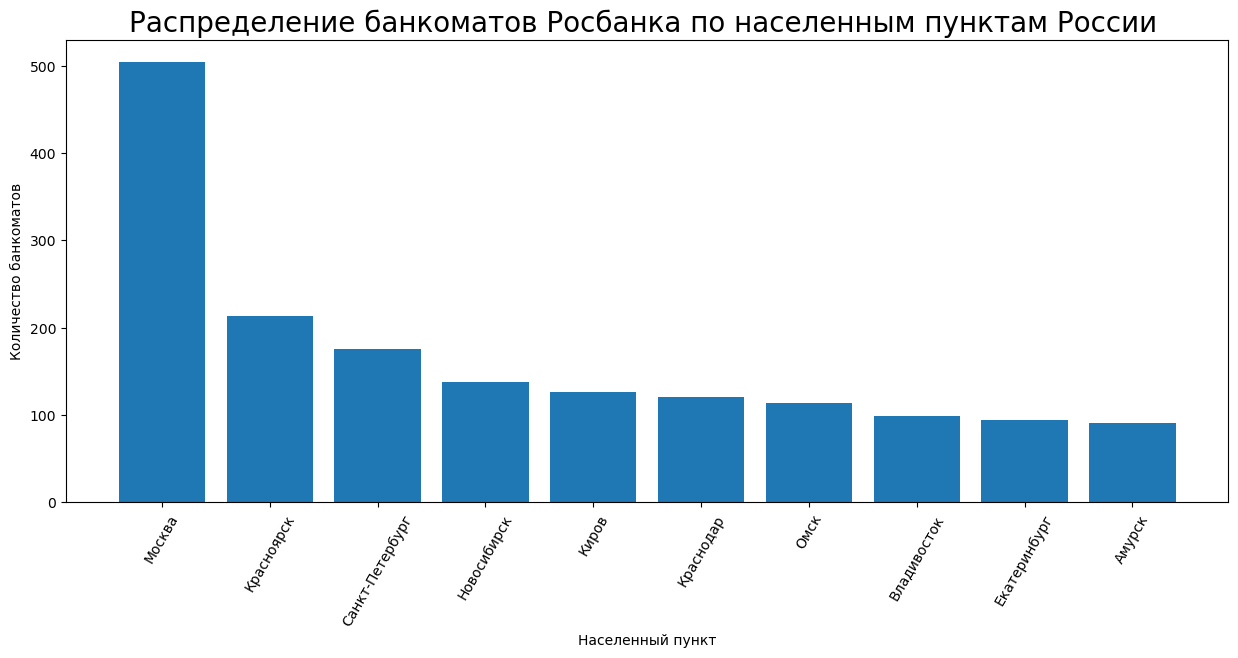

In [177]:
plt.figure(figsize=(15, 6))
plt.bar(x=top_10_atms['settlement'], height=top_10_atms['atm'])
plt.title('Распределение банкоматов Росбанка по населенным пунктам России ', fontsize=20)
sns.color_palette('pastel')
plt.xticks(rotation=60)
plt.xlabel('Населенный пункт')
plt.ylabel('Количество банкоматов')

plt.show()

__12. Посмотрим на распределение таргета:__

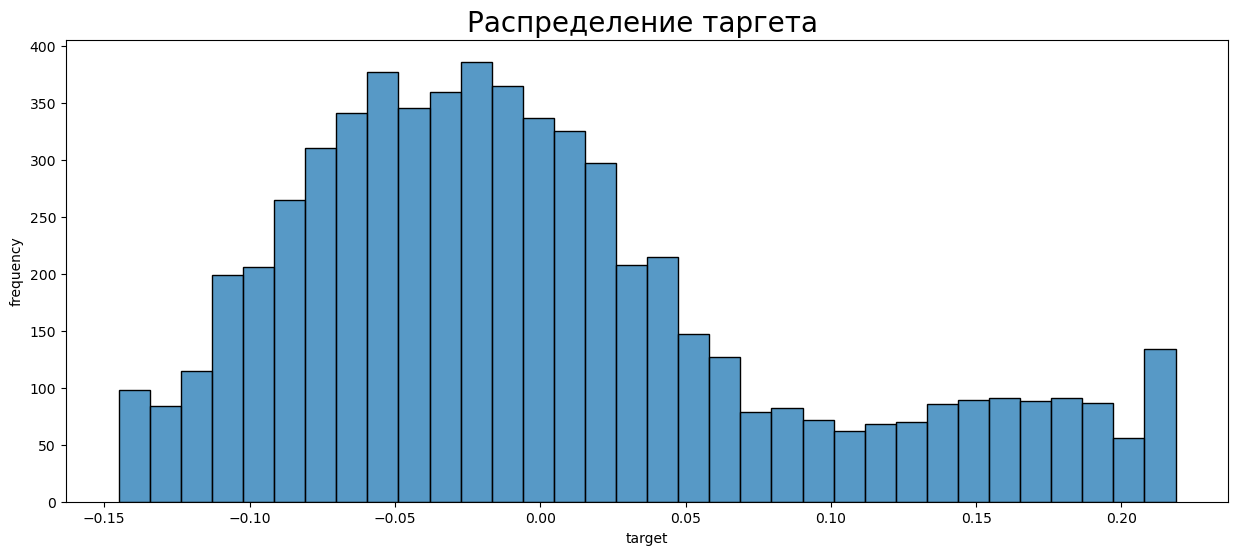

In [180]:
plt.figure(figsize=(15, 6))
plt.title('Распределение таргета ', fontsize=20)
sns.histplot(df_train, x='target')
sns.color_palette('pastel')
plt.xlabel('target')
plt.ylabel('frequency')

plt.show()

In [182]:
print(f'Имеем распределение со средним {df_train.target.mean():.3f} и стандартным отклонением {df_train.target.std():.2f}')

Имеем распределение со средним 0.001 и стандартным отклонением 0.09


In [184]:
df_train['address_rus'][1343]

'Магаданская улица, 31, посёлок Хандыга, Томпонский муниципальный район, Республика Саха (Якутия), Россия, 678720'

Сделаем промежуточный вывод о структуре данных и потенциальных проблемах. По записи 1343 (см. ячейку выше) можно видеть муниципальный формат записи адреса. В муниципальном делении указывают структуры местного самоуправления, например, регион, районы, сельские и городские поселения, муниципальные округа. Данный факт усложняет формат записи адреса для его парсинга на составлящие. Также имеются записи о банкоматах в нашем датасете, адресов на русском с географическими координатами которых нет вовсе.

__13. Построим корреляционную матрицу с количеством банкоматов и городом:__

Для этого сперва закодируем каждый город с помощью Target encoding, т.e. каждую категорию, в нашем случае это город, закодируем средним значением целевой переменной по этой категории.

In [189]:
df_train['settlement'].nunique()

486

In [191]:
df_train['feature_mean'] = df_train.groupby('settlement')['target'].transform('mean')

Если кодировать при помощи счетчиков сразу все обучающие данные, то мы переобучимся. Применим сглаживание по следующей формуле:

$$
p = \frac{\text{mean(target)} \cdot n_{\text{rows}} + \alpha \cdot \text{GlobalTarget}}{n_{\text{rows}} + \alpha}
$$

In [195]:
def counter_with_smoothing(df, settlement, target, alpha):
    """
    p - число, которым кодируем категорию
    n_rows - число строк в категории
    mean(target) - среднее значение целевой переменной по категории
    Global_target - среднее значение целевой переменной по всей обучающей выборке
    α - гиперпараметр
    """
    df['feature_mean'] = df.groupby(settlement)[target].transform('mean')

    global_mean = df[target].mean()

    df['settlement_count'] = df.groupby(settlement)[target].transform('count')

    df['p'] = (df['feature_mean'] * df['settlement_count'] + alpha * global_mean) / (df['settlement_count'] + alpha)

    return df

In [197]:
df_train = counter_with_smoothing(df_train, 'settlement', 'target', 30)

In [199]:
df_train

,id,atm_group,address,address_rus,lat,long,target,len_address,postal_code,len_postal_code,country,settlement,street_name,number,feature_mean,settlement_count,p
0,"8,526.00",32.00,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.94,142.74,0.01,70.00,None,NaN,Россия,Южно-Сахалинск,А.О. Емельянова,34,0.04,28.00,0.02
1,"8,532.00",32.00,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.94,142.75,0.03,69.00,None,NaN,Россия,Комсомольск,Комсомольская,259,0.04,66.00,0.03
2,"8,533.00",32.00,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.96,142.74,0.01,70.00,None,NaN,Россия,Южно-Сахалинск,Коммунистический проспект,None,0.04,28.00,0.02
3,"8,684.00",32.00,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.81,37.52,-0.09,51.00,125315,6.00,Россия,Москва,Ленинградский проспект,76А,0.04,504.00,0.03
4,37.00,32.00,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.34,88.21,0.08,67.00,663302,6.00,Россия,Гвардейск,Гвардейская площадь,2,0.01,5.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6256,"4,402.00","8,083.00","FEDORA POPOVA, 14 Yakutsk","улица Федора Попова, 14, Якутск, Республика Са...",62.05,129.75,0.21,73.00,677009,6.00,Россия,Якутск,Федора Попова,14,0.04,65.00,0.02
6257,"4,421.00","8,083.00","STROITELEY, 43 Novokuznetsk","проспект Строителей, 43, Новокузнецк, Кемеровс...",53.77,87.12,0.06,73.00,654005,6.00,Россия,Новокузнецк,проспект Строителей,43,-0.03,32.00,-0.01
6258,"4,422.00","8,083.00","Rublevskoye sh, 62 Moskva","Рублёвское шоссе, 62, Москва, Россия, 121609",55.77,37.38,0.11,44.00,121609,6.00,Россия,Москва,Рублёвское шоссе,62,0.04,504.00,0.03
6259,"4,426.00","8,083.00","EFANOVA, 22 Zyryanskoye","улица Ефанова, 22, село Зырянское, Зырянский р...",56.84,86.64,0.15,75.00,None,NaN,Россия,Томск,Ефанова,22,0.04,85.00,0.03


<Axes: >

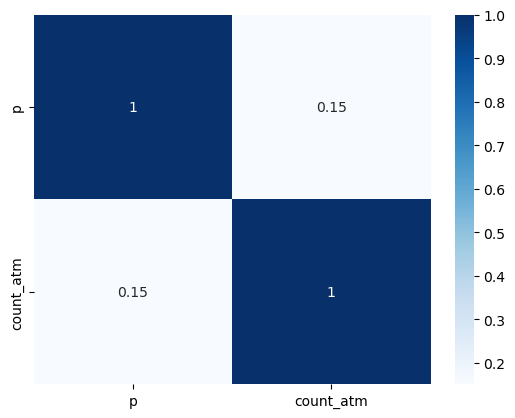

In [201]:
df_corr = df_train.groupby('settlement', as_index=False).agg(count_atm=('lat', 'count'), \
                                                               p=('p', 'mean'))

sns.heatmap(df_corr[['p', 'count_atm']].corr(), cmap="Blues", annot=True)

Попробую проинтепретировать полученное значение: в целом у нас наблюдается положительная корреляция между закодированным числом города и числом банкоматов в нем, но зависимость слабая. Хоть и есть некоторая связь, но она вряд ли объясняет поведение числа банкоматов (count_atm).

__Применим библиотеку Folium для визуализации геоданных наших банкоматов:__

In [154]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [205]:
import folium
from folium.plugins import HeatMap

In [206]:
atm_coordinates = df_train[(df_train['lat'].notnull()) & (df_train['long'].notnull())][['lat', 'long']]

In [207]:
if 'count' not in atm_coordinates.columns:
    atm_coordinates['count'] = 1  # Если нет столбца с весами, назначим по 1 банкомату

# Создаем карту
m = folium.Map(location=[atm_coordinates['lat'].mean(), atm_coordinates['long'].mean()], zoom_start=6)

# Добавляем слой тепловой карты
heat_data = atm_coordinates[['lat', 'long', 'count']].values.tolist()
HeatMap(heat_data).add_to(m)

# Сохраняем карту в HTML
m.save("heatmap.html")
print("Тепловая карта сохранена в файл heatmap.html")

Тепловая карта сохранена в файл heatmap.html


In [217]:
df_train.isna().sum()

id                     0
atm_group              0
address                0
address_rus          304
lat                  304
long                 304
target                 0
len_address          304
postal_code         1563
len_postal_code     1563
country              304
settlement           320
street_name          461
number               503
feature_mean         320
settlement_count     320
p                    320
dtype: int64

## Часть 2 | ML

### 1. Модель только на вещественных числах

Начнем обучение ML моделей с линейной регрессии. Оценивать результаты моделей будем с помощью метрик качества $R^2$, $MAE$ и $MAPE$.

In [228]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE, r2_score as R2

Отберем записи, в которых присутствуют сведения о широте и долготе:

In [230]:
df_train_filtered = df_train[(df_train['lat'].notnull()) & (df_train['long'].notnull())]
df_test_filtered = df_test[(df_test['lat'].notnull()) & (df_test['long'].notnull())]

In [236]:
df_test_filtered['settlement_count'] = df_test_filtered.groupby('settlement')['atm_group'].transform('count')

C:\Users\DNS\AppData\Local\Temp\ipykernel_17244\911936762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_filtered['settlement_count'] = df_test_filtered.groupby('settlement')['atm_group'].transform('count')


In [238]:
df_train_filtered['settlement_count'].fillna(round(df_train_filtered['settlement_count'].median(), 2), inplace=True)
df_test_filtered['settlement_count'].fillna(round(df_test_filtered['settlement_count'].median(), 2), inplace=True)

C:\Users\DNS\AppData\Local\Temp\ipykernel_17244\2602348732.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_filtered['settlement_count'].fillna(round(df_train_filtered['settlement_count'].median(), 2), inplace=True)
C:\Users\DNS\AppData\Local\Temp\ipykernel_17244\2602348732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tra

In [246]:
df_train_filtered.isna().sum()

id                     0
atm_group              0
address                0
address_rus            0
lat                    0
long                   0
target                 0
len_address            0
postal_code         1259
len_postal_code     1259
country                0
settlement            16
street_name          157
number               199
feature_mean          16
settlement_count       0
p                     16
dtype: int64

In [248]:
df_train_filtered.dtypes

id                  float64
atm_group           float64
address              object
address_rus          object
lat                 float64
long                float64
target              float64
len_address         float64
postal_code          object
len_postal_code     float64
country              object
settlement           object
street_name          object
number               object
feature_mean        float64
settlement_count    float64
p                   float64
dtype: object

Разделение данных на признаки (X) и целевую переменную (y):

In [250]:
X_train = df_train_filtered[['lat', 'long', 'settlement_count']]
y_train = df_train_filtered['target']

In [252]:
X_test = df_test_filtered[['lat', 'long', 'settlement_count']]

Обучим модель на тренировочных данных:

In [255]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

Сделаем предсказания на тренировочных данных:

In [258]:
y_train_predict = model_lr.predict(X_train)

Посчитаем метрики качества:

In [261]:
print(f'''Metrics:
mae_train={round(MAE(y_train, y_train_predict), 3)}
mape_train={round(MAPE(y_train, y_train_predict), 3)}
R2_train={round(R2(y_train, y_train_predict), 3)}
''')

Metrics:
mae_train=0.066
mape_train=1.981
R2_train=0.045



Выведем веса модели:

In [264]:
weigths = model_lr.coef_
print("Веса:", weigths)

Веса: [-1.73491054e-05  3.98816467e-04  1.13059512e-04]


### 2. Приведем признаки к одному масштабу

In [273]:
from sklearn.preprocessing import StandardScaler

Обучим стандартизатор на тренировочных данных:

In [276]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

Стандартизируем тренировочные данные:

In [279]:
X_train_scaled = scaler.transform(X_train)

Обучим модель на тренировочных данных, которые стандартизировали:

In [282]:
model_lr_scaled = LinearRegression()

In [284]:
model_lr_scaled.fit(X_train_scaled, y_train)

LinearRegression()

Сделаем предсказания на тренировочных данных:

In [287]:
y_train_scaled_predict = model_lr_scaled.predict(X_train_scaled)

Посчитаем метрики качества:

In [290]:
print(f'''Metrics:
mae_train={round(MAE(y_train, y_train_scaled_predict), 3)}
mape_train={round(MAPE(y_train, y_train_scaled_predict), 3)}
R2_train={round(R2(y_train, y_train_scaled_predict), 3)}
''')

Metrics:
mae_train=0.066
mape_train=1.981
R2_train=0.045



Стандартизация не помогла прибавить в качестве.

Выведем веса модели:

In [294]:
weigths = model_lr_scaled.coef_
print("Веса:", weigths)

Веса: [-7.53963613e-05  1.31678844e-02  1.50872927e-02]


### 2. Добавим категориальные переменные

Обучим модель на сей раз с помощью гребневой (ridge) регрессии и класса GridSearchCV. Кроссвалидируемся по 10-ти фолдам:

Сделаем признами 'atm_group' и 'postal_code' категориальными:

In [296]:
df_train_filtered['atm_group'] = df_train_filtered['atm_group'].astype(object)
df_train_filtered['postal_code'] = df_train_filtered['postal_code'].astype(object)

df_test_filtered['atm_group'] = df_test_filtered['atm_group'].astype(object)
df_test_filtered['postal_code'] = df_test_filtered['postal_code'].astype(object)

C:\Users\DNS\AppData\Local\Temp\ipykernel_17244\3463498348.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered['atm_group'] = df_train_filtered['atm_group'].astype(object)
C:\Users\DNS\AppData\Local\Temp\ipykernel_17244\3463498348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered['postal_code'] = df_train_filtered['postal_code'].astype(object)
C:\Users\DNS\AppData\Local\Temp\ipykernel_17244\3463498348.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [298]:
df_train_filtered.dtypes

id                  float64
atm_group            object
address              object
address_rus          object
lat                 float64
long                float64
target              float64
len_address         float64
postal_code          object
len_postal_code     float64
country              object
settlement           object
street_name          object
number               object
feature_mean        float64
settlement_count    float64
p                   float64
dtype: object

In [300]:
X_train_with_cat = df_train_filtered[['lat', 'long', 'settlement', 'street_name', 'settlement_count', 'atm_group', 'postal_code']]
X_test_with_cat = df_test_filtered[['lat', 'long', 'settlement', 'street_name', 'settlement_count', 'atm_group', 'postal_code']]

In [302]:
from sklearn.preprocessing import OneHotEncoder

Воспользуемся OneHotEncoder:

In [305]:
one_hot_enc = OneHotEncoder(drop='first', handle_unknown='ignore')

Запишем категориальные признаки:

In [308]:
cat_features = ['settlement', 'street_name', 'atm_group', 'postal_code']

Обучим и преобразуем тренировочные данные:

In [311]:
encoded_train = one_hot_enc.fit_transform(X_train_with_cat[cat_features]).toarray()

Преобразуем тестовые данные:

In [314]:
encoded_test = one_hot_enc.transform(X_test_with_cat[cat_features]).toarray()

C:\Users\DNS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Создадим датафреймы для закодированных признаков:

In [317]:
encoded_train_df = pd.DataFrame(encoded_train,
                                columns=one_hot_enc.get_feature_names_out(cat_features),
                                index=X_train_with_cat.index)

In [319]:
encoded_test_df = pd.DataFrame(encoded_test,
                              columns=one_hot_enc.get_feature_names_out(cat_features),
                              index=X_test_with_cat.index)

Дропнем исходные категориальные признаки:

In [322]:
X_train_encoded = pd.concat([X_train_with_cat.drop(columns=cat_features), encoded_train_df], axis=1)
X_test_encoded = pd.concat([X_test_with_cat.drop(columns=cat_features), encoded_test_df], axis=1)

In [323]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

Зададим варианты гиперпараметра alpha, который будем поочереди применять на модели:

In [325]:
params = {'alpha' : [0.01, 0.2, 0.4, 0.6, 0,8, 1]}

In [326]:
ridge_model = Ridge(random_state=42)

Подберем гиперпараметры по кросс-валидации:

In [328]:
ridge = GridSearchCV(ridge_model, params, scoring='r2', cv=10)
ridge.fit(X_train_encoded, y_train)

C:\Users\DNS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\DNS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DNS\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\DNS\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py", line 1251, in fit
    return super().fit(X, y

GridSearchCV(cv=10, estimator=Ridge(random_state=42),
             param_grid={'alpha': [0.01, 0.2, 0.4, 0.6, 0, 8, 1]},
             scoring='r2')

Сделаем предсказания на тренировочных данных:

In [334]:
y_train_encoded_predict = ridge.predict(X_train_encoded)

In [335]:
print(f'''Metrics:
mae_train={round(MAE(y_train, y_train_encoded_predict), 3)}
mape_train={round(MAPE(y_train, y_train_encoded_predict), 3)}
R2_train={round(R2(y_train, y_train_encoded_predict), 3)}
''')

Metrics:
mae_train=0.032
mape_train=2.448
R2_train=0.787



Из полученных результатов видно, чо лучше всех себя проявила модель Ridge. Низкие знаения MAE и MAPE говорят о точности предсказаний, а относительно высокий R2 подтверждает, что модель объясняет значительную часть дисперсии данных. Проинтепретерируем полученные результаты: мы добавили в модель категориальные признаки, которые несут в себе полезную информацию и это помогло модели лучше понять и объяснить данные. 

Нарисуем получившиеся значения метрик для всех моделей:

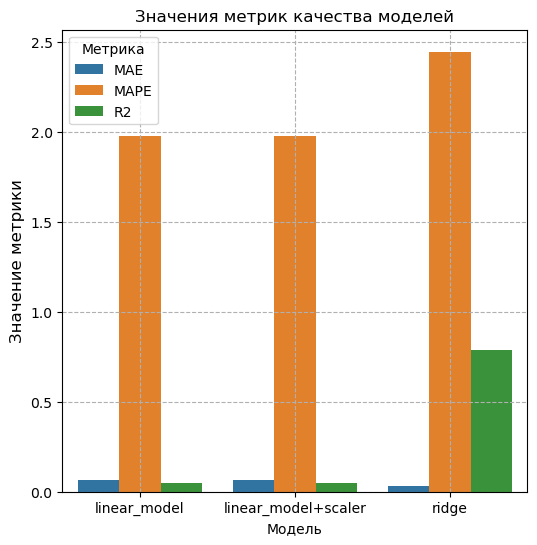

In [813]:
metrics = {
    'Model': ['linear_model', 'linear_model+scaler', 'ridge'],
    'MAE': [0.066, 0.066, 0.032],
    'MAPE': [1.981, 1.981, 2.448],
    'R2': [0.045, 0.045, 0.787]
}

df = pd.DataFrame(metrics)

long_df = df.melt(id_vars='Model', var_name='Metric', value_name='Value')

plt.figure(figsize=(6, 6))
sns.barplot(data=long_df, x='Model', y='Value', hue='Metric')

plt.title('Значения метрик качества моделей')
plt.xlabel('Модель')
plt.ylabel('Значение метрики', fontsize=12)
plt.legend(title='Метрика')
plt.grid(linestyle='--')
plt.show()


### 3. Попытка улучшить предыдущий результат с помощью более корректного проведения обучения и подбора гиперпараметров

In [401]:
from sklearn.model_selection import train_test_split

__Для побучения возьмем следующие признаки:__

In [920]:
cols_for_fit = ['atm_group', 'lat', 'long', 'postal_code', 'settlement', 'street_name', 'settlement_count', 'p', 'target', 'number']

In [928]:
X.isna().sum()

atm_group              0
lat                    0
long                   0
postal_code         1259
settlement            16
street_name          157
settlement_count       0
p                     16
number               199
dtype: int64

In [930]:
X = df_train_filtered[cols_for_fit].drop(columns='target').copy()
y = df_train_filtered['target'].copy()

Заполним пропуски для избежания ошибок:

In [933]:
X_notna = X.copy()

In [934]:
X_notna.isna().sum()

atm_group              0
lat                    0
long                   0
postal_code         1259
settlement            16
street_name          157
settlement_count       0
p                     16
number               199
dtype: int64

__Необходимо обработать имеющиеся пропуски, попробуем сделать следующее:__

In [937]:
X_notna['p'].fillna(X_notna['p'].median(), inplace=True)
X_notna['street_name'].fillna('999', inplace=True)
X_notna['settlement'].fillna(X_notna['settlement'].mode()[0], inplace=True)
X_notna['postal_code'].fillna('-999', inplace=True)   
X_notna['number'].fillna(X_notna['number'].mode(), inplace=True)

C:\Users\DNS\AppData\Local\Temp\ipykernel_17244\4130828119.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_notna['p'].fillna(X_notna['p'].median(), inplace=True)
C:\Users\DNS\AppData\Local\Temp\ipykernel_17244\4130828119.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [939]:
RANDOM_STATE = 42

In [941]:
X_train, X_val, y_train, y_val = train_test_split(X_notna, y, test_size=0.3, random_state=RANDOM_STATE)

In [942]:
numeric_features = X.select_dtypes(include=['float', 'int']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [943]:
scaler = StandardScaler()

In [944]:
X_train_num = scaler.fit_transform(X_train[numeric_features])
X_val_num = scaler.transform(X_val[numeric_features])

In [945]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

In [949]:
X_train_cat = ohe.fit_transform(X_train[categorical_features]).toarray()
X_val_cat = ohe.transform(X_val[categorical_features]).toarray()

C:\Users\DNS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [952]:
X_train_cat_df = pd.DataFrame(X_train_cat,
                              columns=ohe.get_feature_names_out(categorical_features),
                              index=X_train.index)

In [953]:
X_val_cat_df = pd.DataFrame(X_val_cat,
                            columns=ohe.get_feature_names_out(categorical_features),
                            index=X_val.index)

In [954]:
X_train_num_df = pd.DataFrame(X_train_num,
                              columns=scaler.get_feature_names_out(numeric_features),
                              index=X_train.index)

In [955]:
X_val_num_df = pd.DataFrame(X_val_num,
                            columns=scaler.get_feature_names_out(numeric_features),
                            index=X_val.index)

In [956]:
X_train_df = pd.concat([X_train_cat_df, X_train_num_df], axis=1)
X_val_df = pd.concat([X_val_cat_df, X_val_num_df], axis=1)

In [957]:
params = {'alpha': np.logspace(-5, 5, 10)}

In [958]:
ridge_model = Ridge(random_state=RANDOM_STATE)

In [959]:
gs = GridSearchCV(ridge_model, params, scoring='r2', cv=5)
gs.fit(X_train_df, y_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=42),
             param_grid={'alpha': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])},
             scoring='r2')

In [968]:
y_val_predict = gs.best_estimator_.predict(X_val_df)

In [969]:
len(y_val_predict)

1788

In [970]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_val_predict), 3)}
mape_train={round(MAPE(y_val, y_val_predict), 3)}
R2_train={round(R2(y_val, y_val_predict), 3)}
''')

Metrics:
mae_train=0.036
mape_train=1.902
R2_train=0.71



## 4. Применим методы для обрабокти тестов

В качестве методов опробуем:  
- BoW (bag of words);
- TF-IDF
- word2vec

### 1. Реализуем BoW

__1.1__
- Возьмем мешок слов и изучим гребневую регрессию;
- Пропуски в колонках заполним модой по этим колонкам;
- Список признаков для обучения возьмем следующий: atm_group, address_rus, lat, long, postal_code,
settlement, street_name, settlement_count, number, target

In [1257]:
from sklearn.feature_extraction.text import CountVectorizer

In [1259]:
cnt_vec = CountVectorizer(lowercase=True)

In [1487]:
X_df_for_texts = df_train_filtered[['atm_group', 'address_rus', 'lat', 'long', 
                                   'postal_code', 'settlement', 'street_name', 
                                   'settlement_count', 'target', 'number']].reset_index()

In [1489]:
X_df_for_texts.isna().sum()

index                  0
atm_group              0
address_rus            0
lat                    0
long                   0
postal_code         1259
settlement            16
street_name          157
settlement_count       0
target                 0
number               199
dtype: int64

In [1490]:
X_df_for_texts.drop('index', axis=1, inplace=True)

Необходимо обработать имеющиеся пропуски, попробуем сделать следующее:

In [1493]:
X_df_for_texts['street_name'].fillna(df_train_filtered['street_name'].mode()[0], inplace=True)
X_df_for_texts['settlement'].fillna(df_train_filtered['settlement'].mode()[0], inplace=True)
X_df_for_texts['postal_code'].fillna(df_train_filtered['postal_code'].mode()[0], inplace=True) 
X_df_for_texts['number'].fillna(df_train_filtered['number'].mode()[0], inplace=True)

C:\Users\DNS\AppData\Local\Temp\ipykernel_17244\1938884588.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_df_for_texts['street_name'].fillna(df_train_filtered['street_name'].mode()[0], inplace=True)
C:\Users\DNS\AppData\Local\Temp\ipykernel_17244\1938884588.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [1494]:
X_df_for_texts.isna().sum()

atm_group           0
address_rus         0
lat                 0
long                0
postal_code         0
settlement          0
street_name         0
settlement_count    0
target              0
number              0
dtype: int64

In [1497]:
X_train_addresses

,address_rus
0,"улица А.О. Емельянова, 34, Южно-Сахалинск, Сах..."
1,"Комсомольская улица, 259, Южно-Сахалинск, Саха..."
2,"Коммунистический проспект, Южно-Сахалинск, Сах..."
3,"Ленинградский проспект, 76А, Москва, Россия, 1..."
4,"Гвардейская площадь, 2, Норильск, Красноярский..."
...,...
5952,"улица Федора Попова, 14, Якутск, Республика Са..."
5953,"проспект Строителей, 43, Новокузнецк, Кемеровс..."
5954,"Рублёвское шоссе, 62, Москва, Россия, 121609"
5955,"улица Ефанова, 22, село Зырянское, Зырянский р..."


In [1499]:
X_train_addresses = X_df_for_texts[['address_rus']].copy()
y_train_addresses = X_df_for_texts['target'].copy()

In [1501]:
X_bow  = cnt_vec.fit_transform(X_train_addresses['address_rus'])

In [1503]:
X_bow_df = pd.DataFrame(X_bow.toarray(), columns=cnt_vec.get_feature_names_out(), index=X_train_addresses.index)

In [1509]:
df_train_bow = X_df_for_texts.drop(['address_rus'], axis=1)

In [1510]:
df_train_bow = pd.concat([df_train_bow, X_bow_df], axis=1)

In [1511]:
df_train_bow.shape

(5957, 5823)

In [1515]:
df_train_bow

,atm_group,lat,long,postal_code,settlement,street_name,settlement_count,target,number,10,...,ярцевское,ясная,ясногорск,ястынская,ят,ях,яшина,яшкуль,яшкульский,яшьлек
0,32.00,46.94,142.74,677000,Южно-Сахалинск,А.О. Емельянова,28.00,0.01,34,0,...,0,0,0,0,0,0,0,0,0,0
1,32.00,46.94,142.75,677000,Комсомольск,Комсомольская,66.00,0.03,259,0,...,0,0,0,0,0,0,0,0,0,0
2,32.00,46.96,142.74,677000,Южно-Сахалинск,Коммунистический проспект,28.00,0.01,1,0,...,0,0,0,0,0,0,0,0,0,0
3,32.00,55.81,37.52,125315,Москва,Ленинградский проспект,504.00,-0.09,76А,0,...,0,0,0,0,0,0,0,0,0,0
4,32.00,69.34,88.21,663302,Гвардейск,Гвардейская площадь,5.00,0.08,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5952,"8,083.00",62.05,129.75,677009,Якутск,Федора Попова,65.00,0.21,14,0,...,0,0,0,0,0,0,0,0,0,0
5953,"8,083.00",53.77,87.12,654005,Новокузнецк,проспект Строителей,32.00,0.06,43,0,...,0,0,0,0,0,0,0,0,0,0
5954,"8,083.00",55.77,37.38,121609,Москва,Рублёвское шоссе,504.00,0.11,62,0,...,0,0,0,0,0,0,0,0,0,0
5955,"8,083.00",56.84,86.64,677000,Томск,Ефанова,85.00,0.15,22,0,...,0,0,0,0,0,0,0,0,0,0


In [1516]:
X = df_train_bow.drop(columns=['target'])
y = df_train_bow['target']

In [1422]:
X

,atm_group,lat,long,postal_code,settlement,street_name,settlement_count,number,10,100,...,ярцевское,ясная,ясногорск,ястынская,ят,ях,яшина,яшкуль,яшкульский,яшьлек
0,32.00,46.94,142.74,-999,Южно-Сахалинск,А.О. Емельянова,28.00,34,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32.00,46.94,142.75,-999,Комсомольск,Комсомольская,66.00,259,0,0,...,0,0,0,0,0,0,0,0,0,0
2,32.00,46.96,142.74,-999,Южно-Сахалинск,Коммунистический проспект,28.00,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,32.00,55.81,37.52,125315,Москва,Ленинградский проспект,504.00,76А,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32.00,69.34,88.21,663302,Гвардейск,Гвардейская площадь,5.00,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5952,"8,083.00",62.05,129.75,677009,Якутск,Федора Попова,65.00,14,0,0,...,0,0,0,0,0,0,0,0,0,0
5953,"8,083.00",53.77,87.12,654005,Новокузнецк,проспект Строителей,32.00,43,0,0,...,0,0,0,0,0,0,0,0,0,0
5954,"8,083.00",55.77,37.38,121609,Москва,Рублёвское шоссе,504.00,62,0,0,...,0,0,0,0,0,0,0,0,0,0
5955,"8,083.00",56.84,86.64,-999,Томск,Ефанова,85.00,22,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1519]:
numeric_features = X.select_dtypes(include=['float', 'int']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [1520]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [1521]:
scaler = StandardScaler()

In [1523]:
X_train_num = pd.DataFrame(scaler.fit_transform(X_train[numeric_features]), columns=numeric_features, index=X_train.index)

In [1526]:
X_val_num = pd.DataFrame(scaler.transform(X_val[numeric_features]), columns=numeric_features, index=X_val.index)

In [1527]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [1528]:
X_train_cat = pd.DataFrame(ohe.fit_transform(X_train[categorical_features]),
                           columns=ohe.get_feature_names_out(categorical_features),
                           index=X_train.index)

In [1529]:
X_val_cat = pd.DataFrame(ohe.transform(X_val[categorical_features]),
                           columns=ohe.get_feature_names_out(categorical_features),
                           index=X_val.index)

C:\Users\DNS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [1531]:
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_final = pd.concat([X_val_num, X_val_cat], axis=1)

In [1540]:
lr = LinearRegression()
lr.fit(X_train_final, y_train)

LinearRegression()

In [1541]:
y_bow_predict = lr.predict(X_val_final)

In [1542]:
y_bow_predict

array([-1.87547684e-01,  3.74525572e+11,  3.04927826e-02, ...,
        1.22604717e+12, -7.40318298e-02,  2.90616989e-01])

In [1543]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_bow_predict), 3)}
mape_train={round(MAPE(y_val, y_bow_predict), 3)}
R2_train={round(R2(y_val, y_bow_predict), 3)}
''')

Metrics:
mae_train=864254443349.014
mape_train=61143610153456.195
R2_train=-5.6760952441669326e+26



__Как реультат: получили ужасное качество.__

__1.2__
- Возьмем мешок слов и изучим случайный лес;
- Список признаков для обучения возьмем следующие: atm_group, address_rus, lat, long, postal_code,
settlement, street_name, settlement_count, number, target;
- Обучимся на данных, где пропуски в колонках заполнены модой по этим колонкам.


In [1669]:
from sklearn.ensemble import RandomForestRegressor

In [1710]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf.fit(X_train_final, y_train)
y_predict_rf = rf.predict(X_val_final)

In [1711]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_predict_rf), 3)}
mape_train={round(MAPE(y_val, y_predict_rf), 3)}
R2_train={round(R2(y_val, y_predict_rf), 3)}
''')

Metrics:
mae_train=0.035
mape_train=1.813
R2_train=0.722



- __Попробуем теперь подобрать гиперпараметры:__

In [1597]:
params = {"n_estimators": [100, 200, 300, 500],
          "max_depth": [5, 10, 20],  
          "min_samples_split": [2, 5, 10], 
          "min_samples_leaf": [1, 3, 5],  
          "max_features": ["sqrt", "log2"]}

In [1599]:
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

In [1601]:
gs = GridSearchCV(rf, params, cv=5, scoring="r2", n_jobs=-1, verbose=2)

In [1602]:
gs.fit(X_train_final, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\DNS\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='r2', verbose=2)

In [1603]:
best_rf = RandomForestRegressor(**gs.best_params_, random_state=RANDOM_STATE, n_jobs=-1)
best_rf.fit(X_train_final, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=200,
                      n_jobs=-1, random_state=42)

In [1604]:
y_predict_best_rf = best_rf.predict(X_val_final)

In [1606]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_predict_best_rf), 3)}
mape_train={round(MAPE(y_val, y_predict_best_rf), 3)}
R2_train={round(R2(y_val, y_predict_best_rf), 3)}
''')

Metrics:
mae_train=0.055
mape_train=1.206
R2_train=0.342



- __Возьмем в качестве признаков только адреса на русском и попробуем на них обучиться:__

In [1748]:
X_train, X_val, y_train, y_val = train_test_split(X_bow_df, y, test_size=0.3, random_state=RANDOM_STATE)

In [1750]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_predict_rf = rf.predict(X_val)

In [1751]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_predict_rf), 3)}
mape_train={round(MAPE(y_val, y_predict_rf), 3)}
R2_train={round(R2(y_val, y_predict_rf), 3)}
''')

Metrics:
mae_train=0.06
mape_train=2.422
R2_train=0.093



- __Попробуем обучиться на данных, где пропуски заполнены частично модой, а частично новыми категориями:__

In [1759]:
rf.fit(X_train_df, y_train)
y_predict_rf = rf.predict(X_val_df)

In [1763]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_predict_rf), 3)}
mape_train={round(MAPE(y_val, y_predict_rf), 3)}
R2_train={round(R2(y_val, y_predict_rf), 3)}
''')

Metrics:
mae_train=0.034
mape_train=1.801
R2_train=0.728



__1.3__

- Попробуем на мешке слов изучить градиентный бустинг;
- Список признаков для обучения возьмем следующие: atm_group, address_rus, lat, long, postal_code, settlement, street_name, settlement_count, number, target;
- Обучимся на данных, где пропуски в колонках заполнены модой по этим колонкам.Пропуски в колонках заполним модой по этим колонкам.  

In [1708]:
from sklearn.ensemble import GradientBoostingRegressor

In [1797]:
gbr = GradientBoostingRegressor(random_state=RANDOM_STATE)

In [1718]:
gbr.fit(X_train_final, y_train)
y_predict_gbr = gbr.predict(X_val_final)

In [1726]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_predict_gbf), 3)}
mape_train={round(MAPE(y_val, y_predict_gbf), 3)}
R2_train={round(R2(y_val, y_predict_gbf), 3)}
''')

Metrics:
mae_train=0.037
mape_train=1.91
R2_train=0.705



- __Обучимся на данных, где пропуски в колонках заполнены частично модой, а частично новыми категорями:__

In [1769]:
gbr.fit(X_train_df, y_train)
y_predict_gbr = gbr.predict(X_val_df)

In [1771]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_predict_gbf), 3)}
mape_train={round(MAPE(y_val, y_predict_gbf), 3)}
R2_train={round(R2(y_val, y_predict_gbf), 3)}
''')

Metrics:
mae_train=0.037
mape_train=1.878
R2_train=0.715



- Возьмем в качестве признаков только адреса на русском и попробуем на них обучиться:

In [1782]:
X_train, X_val, y_train, y_val = train_test_split(X_bow_df, y, test_size=0.3, random_state=RANDOM_STATE)

In [1784]:
gbr.fit(X_train, y_train)
y_predict_gbf = gbf.predict(X_val)

In [1786]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_predict_gbf), 3)}
mape_train={round(MAPE(y_val, y_predict_gbf), 3)}
R2_train={round(R2(y_val, y_predict_gbf), 3)}
''')

Metrics:
mae_train=0.063
mape_train=1.402
R2_train=0.102



- Попробуем теперь подобрать гиперпараметры:

In [1793]:
params = {"n_estimators": [100, 300, 500], 
          "learning_rate": [0.01, 0.05, 0.1], 
          "max_depth": [3, 5, 7], 
          "min_samples_split": [2, 5, 10], 
          "min_samples_leaf": [1, 3, 5]}

In [1799]:
gs = GridSearchCV(gbr, params, cv=5, scoring="r2", n_jobs=-1, verbose=2)
gs.fit(X_train_df, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='r2', verbose=2)

GradientBoostingRegressor(learning_rate=0.05, max_depth=7, min_samples_split=5,
                          n_estimators=300, random_state=42)

In [1803]:
best_gbr = GradientBoostingRegressor(**gs.best_params_, random_state=RANDOM_STATE)
best_gbr.fit(X_train_df, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=7, min_samples_split=5,
                          n_estimators=300, random_state=42)

In [1805]:
y_predict_gbr = best_gbr.predict(X_val_df)

In [1807]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_predict_gbr), 3)}
mape_train={round(MAPE(y_val, y_predict_gbr), 3)}
R2_train={round(R2(y_val, y_predict_gbr), 3)}
''')

Metrics:
mae_train=0.035
mape_train=1.867
R2_train=0.726



## 2. Реализуем TF-IDF

In [1826]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [1828]:
tfidf_vec = TfidfVectorizer(lowercase=True)

- Возьмем IF-IDF и обучим случайный лес;
- Список признаков для обучения возьмем следующие: atm_group, address_rus, lat, long, postal_code, settlement, street_name, settlement_count, number, target;
- Обучимся на данных, где пропуски в колонках заполнены модой по этим колонкам.

In [1833]:
X_tf_idf  = tfidf_vec.fit_transform(X_train_addresses['address_rus'])

In [1835]:
X_tf_idf_df = pd.DataFrame(X_tf_idf.toarray(), columns=cnt_vec.get_feature_names_out(), index=X_train_addresses.index)

In [1837]:
df_train_tf_idf = X_df_for_texts.drop(['address_rus'], axis=1)

In [1839]:
df_train_tf_idf = pd.concat([df_train_tf_idf, X_tf_idf_df], axis=1)

In [1843]:
X = df_train_tf_idf.drop(columns=['target'])
y = df_train_tf_idf['target']

In [1845]:
numeric_features = X.select_dtypes(include=['float', 'int']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [1847]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [1849]:
scaler = StandardScaler()

In [1851]:
X_train_num = pd.DataFrame(scaler.fit_transform(X_train[numeric_features]), columns=numeric_features, index=X_train.index)
X_val_num = pd.DataFrame(scaler.transform(X_val[numeric_features]), columns=numeric_features, index=X_val.index)

In [1853]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [1855]:
X_train_cat = pd.DataFrame(ohe.fit_transform(X_train[categorical_features]),
                           columns=ohe.get_feature_names_out(categorical_features),
                           index=X_train.index)

X_val_cat = pd.DataFrame(ohe.transform(X_val[categorical_features]),
                           columns=ohe.get_feature_names_out(categorical_features),
                           index=X_val.index)

C:\Users\DNS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [1857]:
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_final = pd.concat([X_val_num, X_val_cat], axis=1)

In [1859]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf.fit(X_train_final, y_train)
y_predict_rf = rf.predict(X_val_final)

In [1861]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_predict_rf), 3)}
mape_train={round(MAPE(y_val, y_predict_rf), 3)}
R2_train={round(R2(y_val, y_predict_rf), 3)}
''')

Metrics:
mae_train=0.035
mape_train=1.811
R2_train=0.727



- __Попробуем теперь подобрать гиперпараметры:__

In [1866]:
params = {"n_estimators": [100, 200, 300, 500],
          "max_depth": [5, 10, 20],  
          "min_samples_split": [2, 5, 10], 
          "min_samples_leaf": [1, 3, 5],  
          "max_features": ["sqrt", "log2"]}

In [1868]:
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

In [1870]:
gs = GridSearchCV(rf, params, cv=5, scoring="r2", n_jobs=-1, verbose=2)

In [1872]:
gs.fit(X_train_final, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='r2', verbose=2)

In [1874]:
best_rf = RandomForestRegressor(**gs.best_params_, random_state=RANDOM_STATE, n_jobs=-1)
best_rf.fit(X_train_final, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_jobs=-1,
                      random_state=42)

In [1876]:
y_predict_best_rf = best_rf.predict(X_val_final)

In [1878]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_predict_best_rf), 3)}
mape_train={round(MAPE(y_val, y_predict_best_rf), 3)}
R2_train={round(R2(y_val, y_predict_best_rf), 3)}
''')

Metrics:
mae_train=0.054
mape_train=1.219
R2_train=0.391



- __Возьмем в качестве признаков только адреса на русском и попробуем на них обучиться:__

In [1885]:
X_train, X_val, y_train, y_val = train_test_split(X_tf_idf_df, y, test_size=0.3, random_state=RANDOM_STATE)

In [1887]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_predict_rf = rf.predict(X_val)

In [1888]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_predict_rf), 3)}
mape_train={round(MAPE(y_val, y_predict_rf), 3)}
R2_train={round(R2(y_val, y_predict_rf), 3)}
''')

Metrics:
mae_train=0.06
mape_train=2.257
R2_train=0.088



- __Попробуем обучиться на данных, где пропуски заполнены частично модой, а частично новыми категориями:__

In [1895]:
rf.fit(X_train_df, y_train)
y_predict_rf = rf.predict(X_val_df)

In [1897]:
print(f'''Metrics:
mae_train={round(MAE(y_val, y_predict_rf), 3)}
mape_train={round(MAPE(y_val, y_predict_rf), 3)}
R2_train={round(R2(y_val, y_predict_rf), 3)}
''')

Metrics:
mae_train=0.034
mape_train=1.801
R2_train=0.728

